### This is the notebook for analyzing LUAD data

In [104]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import gseapy as gp
from gseapy import barplot, dotplot
from gseapy import Msigdb

import mygene
mg = mygene.MyGeneInfo()

import sys
sys.path.append("..")

from scripts.utility_functions import t_test

cancer_type = "LUAD"
omic_type = "proteomics"

##### Step 1: organize the data into anndata object

In [4]:

# Tumor file
sample_type = "Tumor"
file_tumor = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Data/{cancer_type}_{omic_type}_gene_abundance_log2_reference_intensity_normalized_{sample_type}.txt"

# Normal file
sample_type = "Normal"
file_normal = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Data/{cancer_type}_{omic_type}_gene_abundance_log2_reference_intensity_normalized_{sample_type}.txt"

# Read data
df_tumor = pd.read_csv(file_tumor, sep="\t")
df_normal = pd.read_csv(file_normal, sep="\t")

# Rename the sample names (orignal sample name are same in tumor and normal file, majority of normal samples are matched normal controls)
df_normal = df_normal.rename(columns={col: f"{col}_N" for col in df_normal.columns if col != "idx"})
df_tumor = df_tumor.rename(columns={col: f"{col}_T" for col in df_tumor.columns if col != "idx"})
df_merged = pd.merge(df_normal, df_tumor, on="idx", how="inner")

# The transposed_df is now in the correct format with samples as rows and genes as columns
df_merged.set_index(df_merged.columns[0], inplace=True)
df_transposed = df_merged.T

In [ ]:
### Make the anndata object
obs=pd.DataFrame(
    index=df_transposed.index, 
    data={
        'SampleType': df_transposed.index.str[-1],  # Last character
        'Sample': df_transposed.index.str[:-2]      # All but last two characters
    }
)

var=pd.DataFrame(
    index=df_transposed.columns, 
    data={
        "ensembl_ids_clean" : [x.split(".")[0] for x in df_transposed.columns]
    }
)

adata = ad.AnnData(
    X=df_transposed,
    obs=obs,
    var=var
)

print(adata)

In [ ]:
### Get gene symbol for ensembl ids (cleaned)
gene_info = mg.querymany(adata.var['ensembl_ids_clean'], scopes="ensembl.gene", fields = "symbol", species="human")
gene_symbols = {item['query']: item.get('symbol', None) for item in gene_info}

# Create a DataFrame to map Ensembl IDs to Gene Symbols
gene_mapping = pd.DataFrame(list(gene_symbols.items()), columns=['ensembl_ids_clean', 'Gene'])

# Merge with adata.var to add Gene_Symbol
adata.var = adata.var.join(gene_mapping.set_index("ensembl_ids_clean"), on='ensembl_ids_clean', how='left')

assert (adata.var.index == df_transposed.columns).all()
assert (adata.obs.index == df_transposed.index).all()

In [ ]:
adata.var_names
adata.var
#adata.obs


In [ ]:
object_file = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Object/{cancer_type}_{omic_type}.h5ad"

adata.write(object_file, compression="gzip")

##### Step 2: ML

In [ ]:
### Main ML workflow 

# Load data
object_file = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Object/{cancer_type}_{omic_type}.h5ad"
adata = ad.read_h5ad(object_file)

X = adata.X
y_ori = adata.obs["SampleType"].values
#samples = adata.obs["Sample"].values  # sample names or IDs
samples_type = adata.obs["SampleType"].values
samples = adata.obs.index

# Encode labels
# LabelEncoder assigns integers alphabetically by default, so if your labels are "N" and "T" you’ll usually get "Normal" = 0, "Tumor" = 1
encoder = LabelEncoder()
y = encoder.fit_transform(y_ori)

# Ensure "Normal" = 0, "Tumor" = 1
if encoder.transform(["T"])[0] == 0:
    y = 1 - y  # flip labels

# Split train/test and also get the indices of the test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, range(len(y)), test_size=0.3, random_state=42, stratify=y, shuffle=True
)

adata_train = adata[samples[idx_train], ]
adata_test = adata[samples[idx_test], ]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

adata_train = t_test(adata_obj = adata_train, sample_type_col= "SampleType", left_type = "T", right_type="N")

adata_train.var["feature_importance"] = rf.feature_importances_


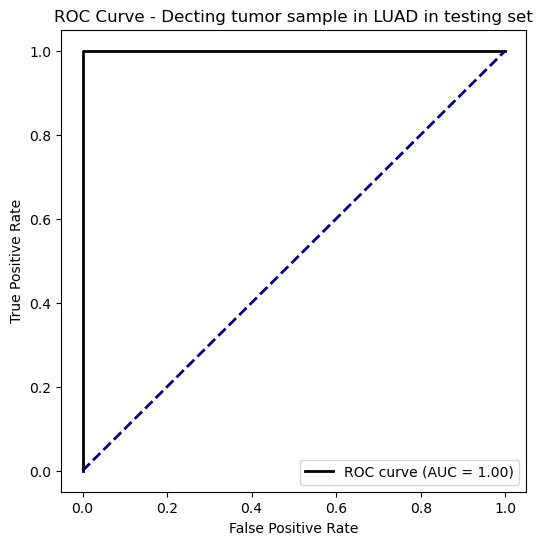

In [ ]:

### Prediction
y_proba = rf.predict_proba(X_test)[:, 1]  # Probability of class 1 (Tumor)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color = "black", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color = "navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - Decting tumor sample in {cancer_type} in testing set")
plt.legend(loc="lower right")

# Save to PDF
pdf_file = f"../results/figures/{cancer_type}_{omic_type}_ROC_in_testing_set.pdf"
plt.savefig(pdf_file, format="pdf", bbox_inches="tight")

plt.show()


    idx_test       Sample Sample_Type  y_test  y_pred
0         32  C3L-00095_N           N       0   0.054
1         51  C3L-01632_N           N       0   0.026
2          2  C3N-00572_N           N       0   0.006
3        103  C3N-00572_T           T       1   0.850
4         21  C3L-01682_N           N       0   0.002
..       ...          ...         ...     ...     ...
59        20  C3N-02089_N           N       0   0.006
60       107  C3N-01410_T           T       1   0.984
61       207  C3N-00175_T           T       1   0.964
62        14  C3N-00552_N           N       0   0.030
63       178  C3L-01924_T           T       1   0.978

[64 rows x 5 columns]


/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/88673498.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=performance, x="Sample_Type", y="y_pred", palette=custom_palette)


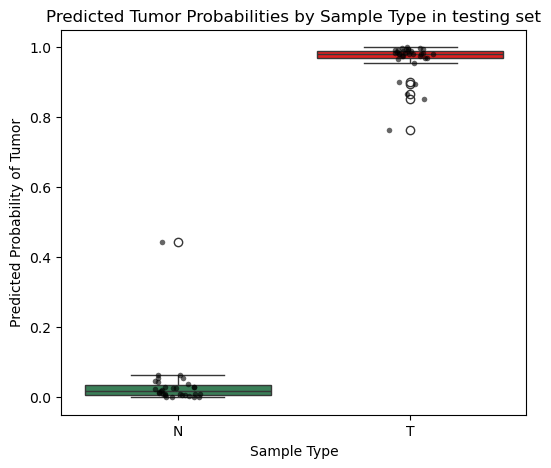

In [141]:

### Create performance DataFrame with Sample info and visualize the proba in testing set
performance = pd.DataFrame({
    "idx_test": idx_test,
    "Sample": samples[idx_test],   # sample names
    "Sample_Type": samples_type[idx_test],
    "y_test": y_test,
    "y_pred": y_proba
})

print(performance)

performance_sort = performance.sort_values("y_pred").reset_index(drop=True)

#pd.set_option("display.max_rows", None)
#print(performance_sort)

### Boxplot on the prediction score in testing set
custom_palette = {"N": "seagreen", "T": "red"}

plt.figure(figsize=(6,5))
sns.boxplot(data=performance, x="Sample_Type", y="y_pred", palette=custom_palette)
sns.stripplot(data=performance, x="Sample_Type", y="y_pred", color="black", size=4, jitter=True, alpha=0.6)
plt.ylabel("Predicted Probability of Tumor")
plt.xlabel("Sample Type")
plt.title("Predicted Tumor Probabilities by Sample Type in testing set")

# Save to PDF
pdf_file = f"../results/figures/{cancer_type}_{omic_type}_Proba_in_testing_set.pdf"
plt.savefig(pdf_file, format="pdf", bbox_inches="tight")

plt.show()

In [135]:
feature_importance_sort = adata_train.var.sort_values(by="feature_importance", ascending=False)
feature_importance_sort.head(5)

,ensembl_ids_clean,Gene,left_mean,right_mean,diff_mean,t_vals,p_vals,feature_importance
idx,,,,,,,,
ENSG00000117114.20,ENSG00000117114,ADGRL2,22.20067387514159,23.65135742668519,-1.450684,-29.578401,2.775148e-63,0.015945
ENSG00000196616.14,ENSG00000196616,ADH1B,28.717328258679643,30.914805843544737,-2.197478,-29.519311,8.315022e-56,0.013945
ENSG00000173210.19,ENSG00000173210,ABLIM3,24.639789868330624,26.028453269353893,-1.388663,-27.651110,5.910782e-58,0.013888
ENSG00000173473.11,ENSG00000173473,SMARCC1,24.67427752286056,23.91907144441469,0.755206,17.147164,7.636197e-31,0.012000
ENSG00000182010.11,ENSG00000182010,RTKN2,22.96113292768406,25.01886721004053,-2.057734,-33.621280,6.963096e-69,0.012000


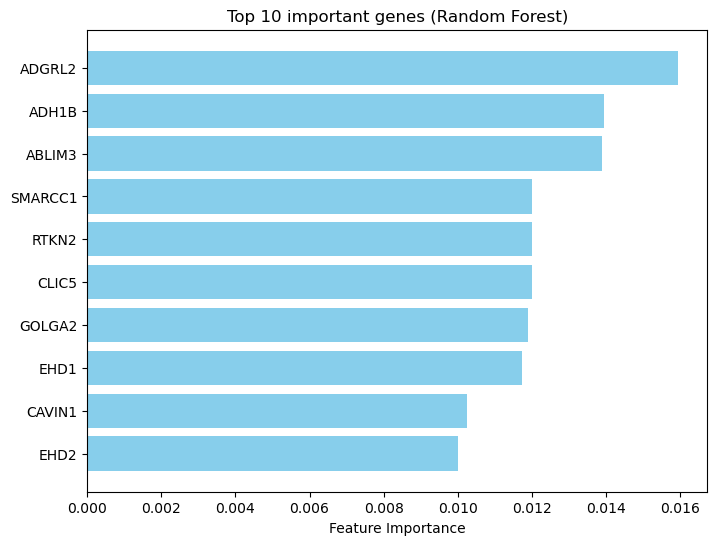

In [10]:
top_n = 10
plt.figure(figsize=(8,6))
plt.barh(
    feature_importance_sort['Gene'][:top_n][::-1],
    feature_importance_sort['feature_importance'][:top_n][::-1],
    color='skyblue'
)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} important genes (Random Forest)")
plt.show()


#### Step 3: Explore the features with biological input

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/1042211150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


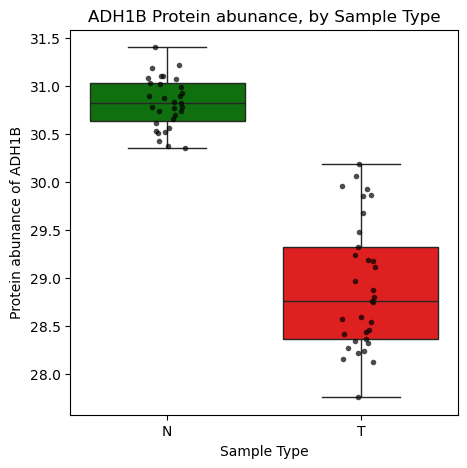

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/1042211150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


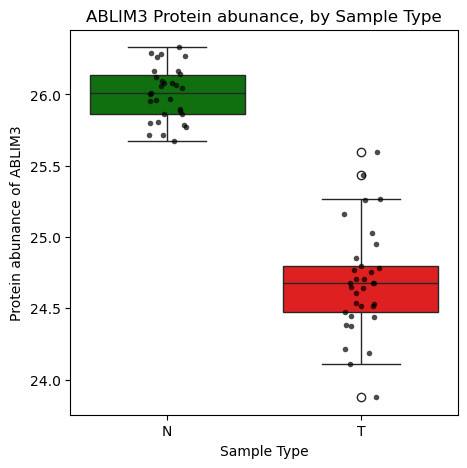

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/1042211150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


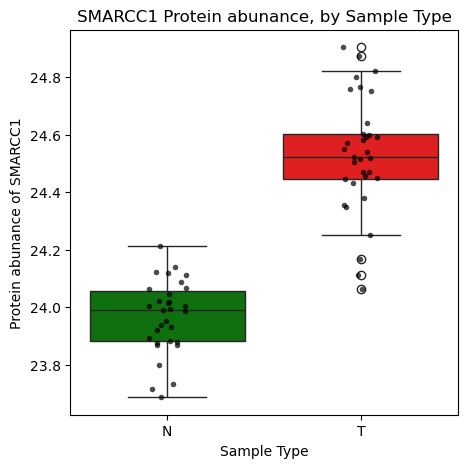

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/1042211150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


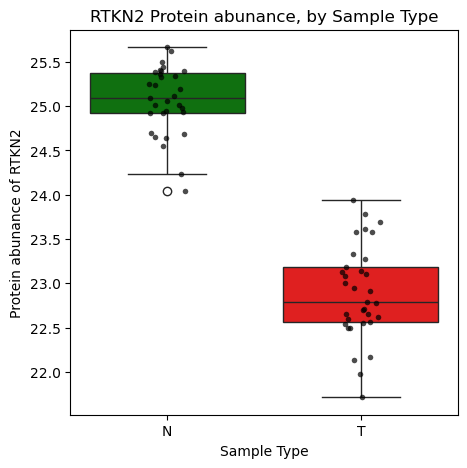

In [ ]:
### Boxplot on important genes in testing set
selected_genes = feature_importance_sort.iloc[1:5, ].index.to_list()

df = pd.DataFrame(
    adata_test.X, 
    index=adata_test.obs.index,
    columns=adata_test.var.index  # or adata.var['Gene'] if you prefer gene symbols
).join(adata_test.obs)


for gene in selected_genes:
    plt.figure(figsize=(5,5))
    sns.boxplot(
        data=df, 
        x="SampleType", 
        y=gene, 
        palette={"N": "green", "T": "red"}
    )
    sns.stripplot(
        data=df, 
        x="SampleType", 
        y=gene, 
        color="black", 
        size=4, 
        jitter=True, 
        alpha=0.7
    )
    plt.ylabel(f"Protein abunance of {adata.var.loc[gene, 'Gene']}")
    plt.xlabel("Sample Type")
    plt.title(f"{adata.var.loc[gene, 'Gene']} Protein abunance, by Sample Type")
    plt.show()



Total number of samples: 64


/Users/Wendy/miniconda3/envs/multiomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/Wendy/miniconda3/envs/multiomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 900x900 with 0 Axes>

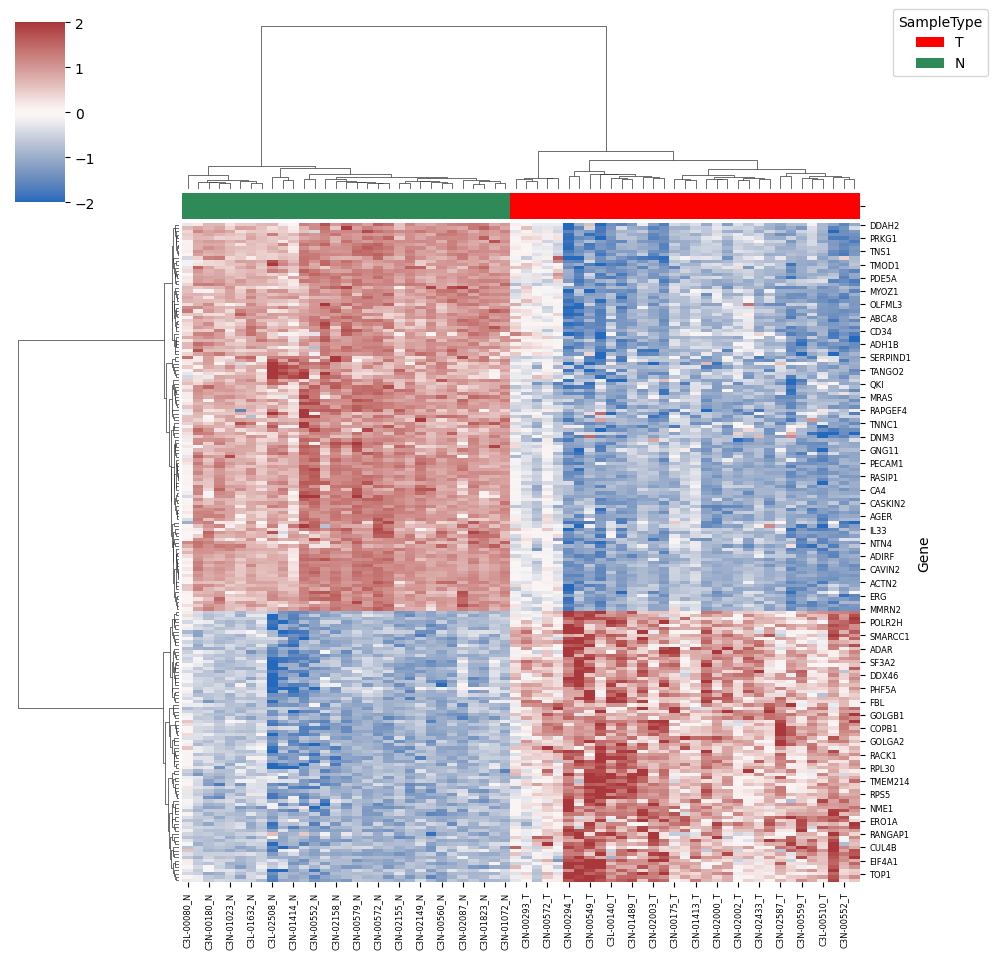

In [ ]:

### Heatmap on top 200 important genes on testing set

selected_genes = feature_importance_sort.iloc[1:200, ].index.to_list()
adata_test_selected_genes = adata_test[:, selected_genes]

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(adata_test_selected_genes.X),
    columns=adata_test_selected_genes.var["Gene"],    # genes
    index=adata_test_selected_genes.obs.index   # samples
)
df_scaled_T = df_scaled.T
# Map disease status to colors
disease_status_col = "SampleType"
lut = {"T": "red", "N": "seagreen"}
dict_colors = adata_test_selected_genes.obs[disease_status_col].map(lut).to_dict()
col_colors = pd.Series(dict_colors)[df_scaled_T.columns]

print(f"Total number of samples: {len(col_colors)}")

# Cluster map
fig = plt.figure(figsize =(9,9))
g= sns.clustermap(
    df_scaled_T,
    col_colors=col_colors,
    cmap="vlag",
    method="ward",
    center=0,
    vmin=-2,
    vmax=2,
    xticklabels=True,
    yticklabels=True
)
# Option 2: Skip some labels (subsample)
yticks = g.ax_heatmap.get_yticks()              # tick positions
ylabels = [lab.get_text() for lab in g.ax_heatmap.get_yticklabels()]  # label texts

skip = 4  # show every 5th gene
g.ax_heatmap.set_yticks(yticks[::skip])
g.ax_heatmap.set_yticklabels(ylabels[::skip], fontsize=6, rotation=0)

# Option 2: Skip some labels (subsample)
xticks = g.ax_heatmap.get_xticks()              # tick positions
xlabels = [lab.get_text() for lab in g.ax_heatmap.get_xticklabels()]  # label texts

skip = 2  # show every 5th gene
g.ax_heatmap.set_xticks(xticks[::skip])
g.ax_heatmap.set_xticklabels(xlabels[::skip], fontsize=6, rotation=90)


# Legend
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(
    handles,
    lut,
    title=disease_status_col,
    bbox_to_anchor=(1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc="upper right"
)
plt.show()


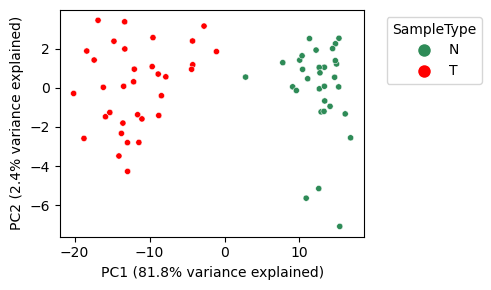

In [ ]:

### PCA on top 200 important genes on testing set

scaler = StandardScaler()
df_scaled = scaler.fit_transform(adata_test_selected_genes.X)
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(
    data = pca_result[:, :2],
    columns= ['PC1', 'PC2'],
    index = adata_test_selected_genes.obs.index
).join(adata_test_selected_genes.obs)

var_explained = pca.explained_variance_ratio_ * 100

disease_status_col = "SampleType"

color_dict = {
    'T': 'red',      # Red
    'N': 'seagreen'   # Green
}
legend_order = ['N', 'T']

fig = plt.figure(figsize =(6,3))
sns.scatterplot(
    data = df_pca,
    x = 'PC1',
    y = 'PC2',
    hue = disease_status_col,
    s = 20,
    palette=color_dict
)

plt.xlabel(f'PC1 ({var_explained[0]:.1f}% variance explained)')
plt.ylabel(f'PC2 ({var_explained[1]:.1f}% variance explained)')

# Create handles and labels in the specific order
handles = []
labels = []
for category in legend_order:
    if category in color_dict:  # Make sure the category exists in your dictionary
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[category], markersize=10))
        labels.append(category)

# Create the legend with the ordered handles and labels
plt.legend(handles, labels, title=disease_status_col, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()



/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/759821455.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  glist = feature_importance_sort.iloc[0:200, ][feature_importance_sort["diff_mean"] > 0]["Gene"].to_list()


               Gene_set                       Term Overlap       P-value  \
0  MSigDB_Hallmark_2020             Myc Targets V1  15/200  3.259707e-15   
1  MSigDB_Hallmark_2020  Unfolded Protein Response   5/113  1.016419e-04   
2  MSigDB_Hallmark_2020                 Glycolysis   6/200  1.727783e-04   
3  MSigDB_Hallmark_2020          Protein Secretion    4/96  6.547167e-04   
4  MSigDB_Hallmark_2020            G2-M Checkpoint   5/200  1.391491e-03   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      6.519415e-14            0                     0   23.880194   
1      1.016419e-03            0                     0   11.910774   
2      1.151856e-03            0                     0    8.026587   
3      3.273584e-03            0                     0   11.051282   
4      4.638304e-03            0                     0    6.567766   

   Combined Score                                              Genes  
0      796.574938  EIF4A1;SMARCC1;RPS5;CSTF2;EIF2S2

<Axes: title={'center': 'UpRegulated 82 proteins from top 200 features'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

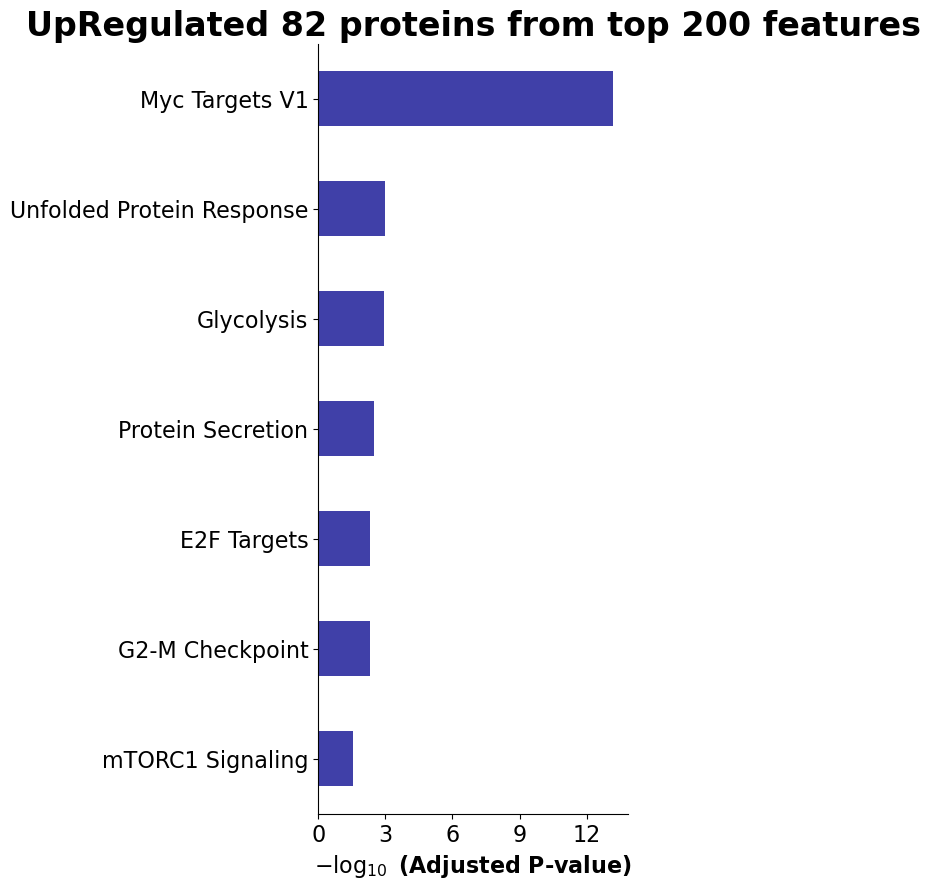

In [139]:
feature_importance_sort = adata_train.var.sort_values(by="feature_importance", ascending=False)
glist = feature_importance_sort.iloc[0:200, ][feature_importance_sort["diff_mean"] > 0]["Gene"].to_list()
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=glist, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
print(enr.results.head(5))
barplot(enr.results, title=f'UpRegulated {len(glist)} proteins from top 200 features', figsize=(4, 10), color='darkblue')

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_15658/451442929.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  glist = feature_importance_sort.iloc[0:200, ][feature_importance_sort["diff_mean"] < 0]["Gene"].to_list()


               Gene_set                  Term Overlap       P-value  \
0  MSigDB_Hallmark_2020            Myogenesis  11/200  2.859266e-08   
1  MSigDB_Hallmark_2020  IL-2/STAT5 Signaling   5/199  6.554012e-03   
2  MSigDB_Hallmark_2020               Hypoxia   5/200  6.691071e-03   
3  MSigDB_Hallmark_2020          Adipogenesis   5/200  6.691071e-03   
4  MSigDB_Hallmark_2020       Apical Junction   5/200  6.691071e-03   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.148166e-07            0                     0   10.711714   
1      3.345536e-02            0                     0    4.490466   
2      3.345536e-02            0                     0    4.467211   
3      3.345536e-02            0                     0    4.467211   
4      3.345536e-02            0                     0    4.467211   

   Combined Score                                              Genes  
0      186.063717  MRAS;MYO1C;ACTN2;TNNC1;FHL1;PYGM;LDB3;CD36;MYO...  
1       22

<Axes: title={'center': 'DownRegulated 118 proteins from top 200 features'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

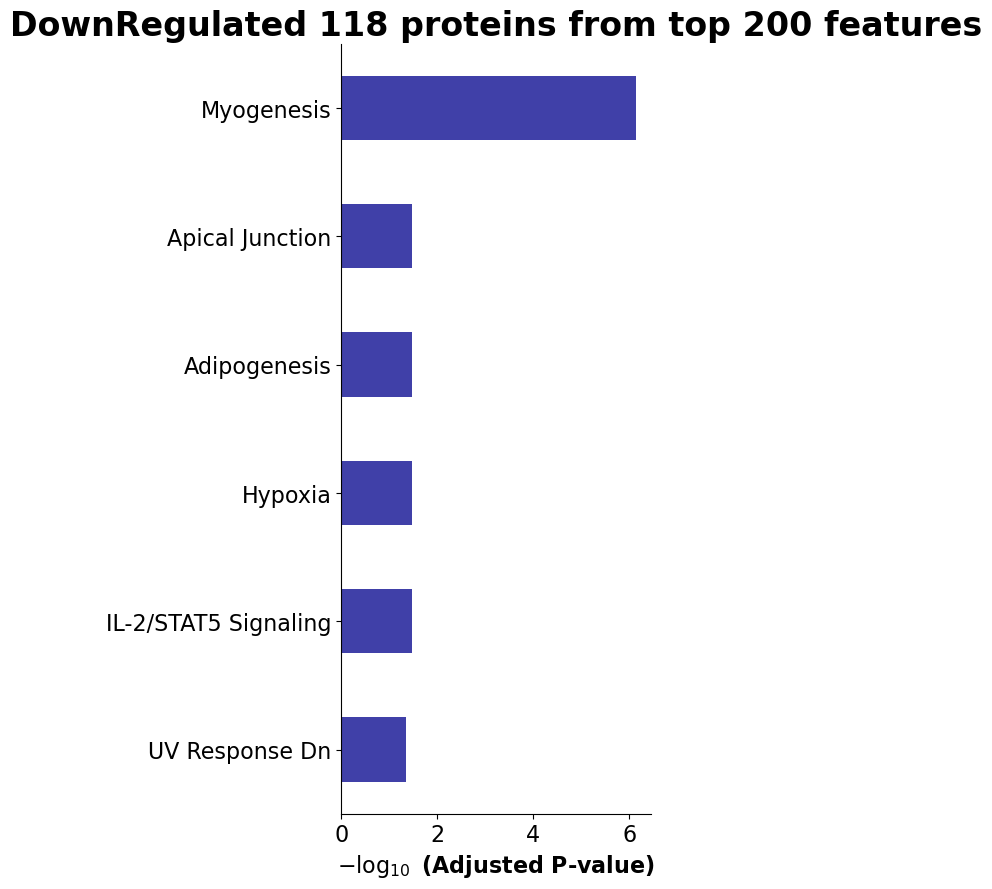

In [140]:
feature_importance_sort = adata_train.var.sort_values(by="feature_importance", ascending=False)
glist = feature_importance_sort.iloc[0:200, ][feature_importance_sort["diff_mean"] < 0]["Gene"].to_list()
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=glist, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
print(enr.results.head(5))
barplot(enr.results, title=f'DownRegulated {len(glist)} proteins from top 200 features', figsize=(4, 10), color='darkblue')